# Setup notebook

In [707]:
import os
import sys
from collections import namedtuple

import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import statsmodels.api as sm
import utide
from joblib import Parallel, delayed
from matplotlib import dates as mdates
from matplotlib import pyplot as plt
from scipy.signal import argrelmax, argrelmin, find_peaks
from scipy.optimize import least_squares
from sklearn.linear_model import LinearRegression

sys.path.append("..")
from src import definitions as defs
from src import features, models

%load_ext autoreload
%autoreload 2
%matplotlib widget
%config Completer.use_jedi = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [708]:
wdir = defs.ROOT / "data"

# Pre-process Mongla Tidal Data

Import data to pandas dataframe

In [709]:
freq = "30 min"
n_per_hour = pd.Timedelta("1 hour") / pd.Timedelta(freq)
data = pd.read_csv(wdir / "raw" / "mongla_tides.csv", index_col="datetime", parse_dates=True, infer_datetime_format=True)
data = data.reindex(pd.date_range(start=data.index[0], end=data.index[-1], freq=freq, name="datetime")).interpolate(method="time", limit=1, limit_direction="both")
data = data.loc[(data.index[-1] - pd.DateOffset(years=19)).ceil("D"):]

In [710]:
nulls = data.elevation.isnull().groupby(pd.Grouper(freq="MS")).sum()
total = data.elevation.groupby(pd.Grouper(freq="MS")).size()
frac_missing = nulls / total
exclude = frac_missing.loc[frac_missing > 0.3].index

In [716]:
daily = data.groupby(by=pd.Grouper(freq="D")).agg(["max", "min"])
monthly = daily.groupby(by=pd.Grouper(freq="MS")).agg("mean").rename(columns={"max": "MHW", "min": "MLW"})
monthly.columns = monthly.columns.droplevel(0)
month_median = data.elevation.groupby(by=pd.Grouper(freq="MS")).agg("median")
monthly = monthly.loc[~monthly.index.isin(exclude)]
month_median = month_median.loc[~month_median.index.isin(exclude)]

In [987]:
phase_start = pd.to_datetime("2003-06-01")
time = ((monthly.index - phase_start) / pd.Timedelta("365.25 days")).values
z = (monthly.MHW - month_median).rolling(pd.Timedelta("365.25 days"), center=True).median().values
w1 = 2 * np.pi / 18.61
w2 = 2 * np.pi / 4.4

In [988]:
def eq1(x, b0, b1, b2, b3, b4, b5):
    w1 = 2 * np.pi / 18.61
    w2 = 2 * np.pi / 4.4
    H = b0 + b1 * x + b2 * np.cos(w1 * x) + b3 * np.sin(w1 * x) + b4 * np.cos(w2 * x) + b5 * np.sin(w2 * x)
    return(H)

In [989]:
popt, pcov = curve_fit(f=eq1, xdata=time, ydata=z)
b0, b1, b2, b3, b4, b5 = popt

A18 = np.sqrt(b2**2 + b3**2)
P18 = np.arctan(b3 / b2)

A4 = np.sqrt(b4**2 + b5**2)
P4 = np.arctan(b5 / b4)

LT = b1 * time
LP = b4 * np.cos(w2 * time) + b5 * np.sin(w2 * time)

In [990]:
A4 > 0.01, A4 > A18 * 0.4

(True, True)

In [991]:
z_filt = z - LT - LP

In [992]:
def eq2(x, b2, b3):
    w1 = 2 * np.pi / 18.61
    H = b2 * np.cos(w1 * x) + b3 * np.sin(w1 * x)
    return(H)

In [1027]:
popt_filt, pcov_filt = curve_fit(f=eq2, xdata=time, ydata=z_filt)
b2_filt, b3_filt = popt_filt

A18_filt = np.sqrt(b2_filt**2 + b3_filt**2)
P18_filt = np.arctan(b3_filt / b2_filt)

In [1035]:
N = A18_filt * np.sin(w1 * time + P18_filt)
N1 = b2_filt * np.cos(w1 * time) + b3_filt * np.sin(w1 * time)

In [1036]:
monthly["MHW_n"] = monthly.MHW - N / 2
monthly["MLW_n"] = monthly.MLW + N / 2

In [1037]:
def lm_tides(data, ref_date=None, time_unit="365.25 days"):
    from collections import namedtuple

    if ref_date == None:
        ref_date = data.index[0]

    LM = namedtuple("LM", "coef, intercept , lin_ts, ts")

    x = ((data.index - ref_date) / pd.Timedelta(time_unit)).values.reshape(-1, 1)
    y = data.values.reshape(-1, 1)
    lm = LinearRegression().fit(x, y)

    lin_ts = pd.Series(data=lm.predict(x[[0, -1]]).flatten(), index=data.iloc[[0, -1]].index)

    return(LM(lm.coef_[0,0], lm.intercept_[0], lin_ts, data))

In [1038]:
lms = monthly.apply(func=lm_tides, result_type="reduce")

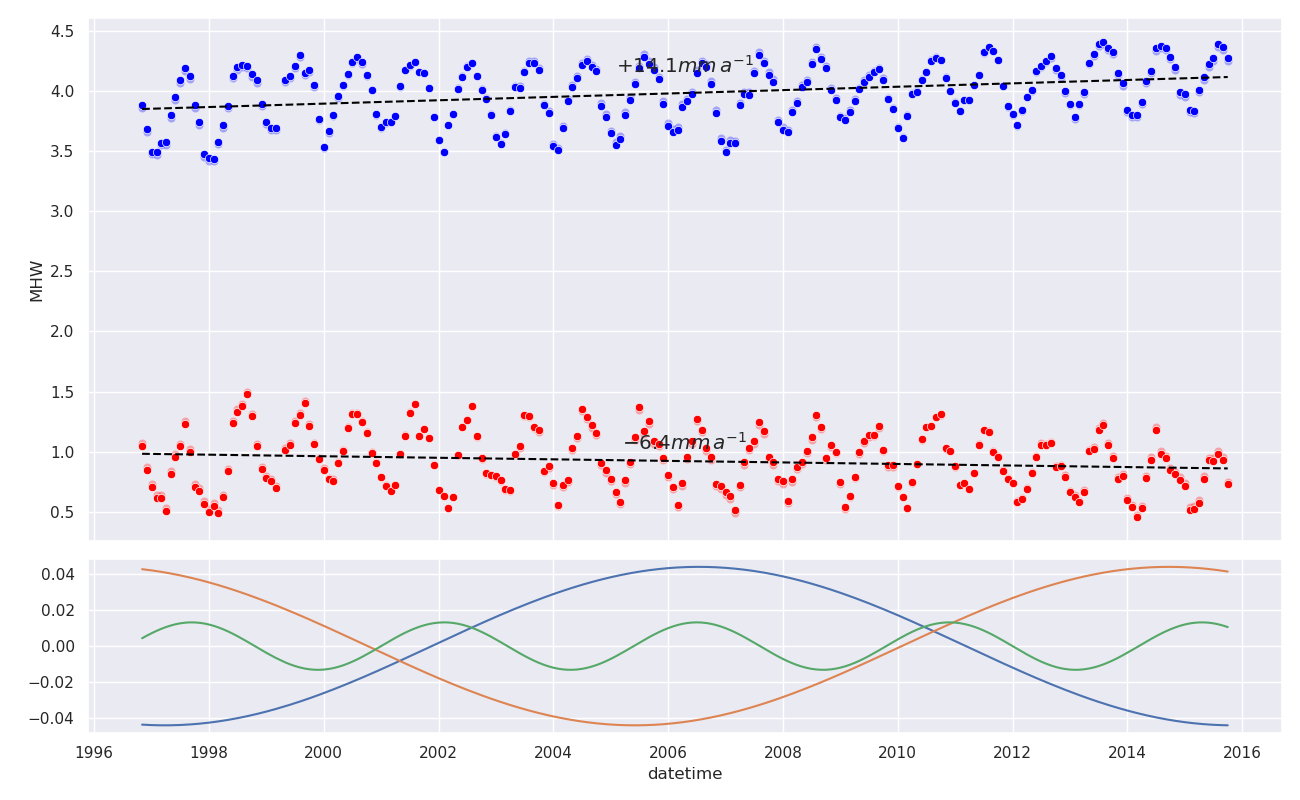

In [1039]:
fig = plt.figure(figsize=(13, 8))
axs = fig.subplots(nrows=2, ncols=1, sharex=True, gridspec_kw={'height_ratios': [3, 1]})

sns.scatterplot(data=lms.MHW.ts, color="blue", alpha=0.3, ax=axs[0])
sns.scatterplot(data=lms.MHW_n.ts, color="blue", ax=axs[0])
sns.lineplot(data=lms.MHW_n.lin_ts, ls="--", color="black", ax=axs[0])
axs[0].text(x=lms.MHW_n.lin_ts.index.mean(), y=lms.MHW_n.lin_ts.max(), ha="center", va="bottom", zorder=30, s="${:+.1f} mm \, a^{{-1}}$".format(lms.MHW_n.coef * 1000), fontsize="large", fontweight="bold")

sns.scatterplot(data=lms.MLW.ts, color="red", alpha=0.3, ax=axs[0])
sns.scatterplot(data=lms.MLW_n.ts, color="red", ax=axs[0])
sns.lineplot(data=lms.MLW_n.lin_ts, ls="--", color="black", ax=axs[0])
axs[0].text(x=lms.MLW_n.lin_ts.index.mean(), y=lms.MLW_n.lin_ts.max(), ha="center", va="bottom", zorder=30, s="${:+.1f} mm \, a^{{-1}}$".format(lms.MLW_n.coef * 1000), fontsize="large", fontweight="bold")

sns.lineplot(x=monthly.index, y=N, ax=axs[1])
sns.lineplot(x=monthly.index, y=N1, ax=axs[1])
# sns.lineplot(x=monthly.index, y=LT, ax=axs[1])
sns.lineplot(x=monthly.index, y=LP, ax=axs[1])
fig.tight_layout()

ValueError: All arrays must be of the same length

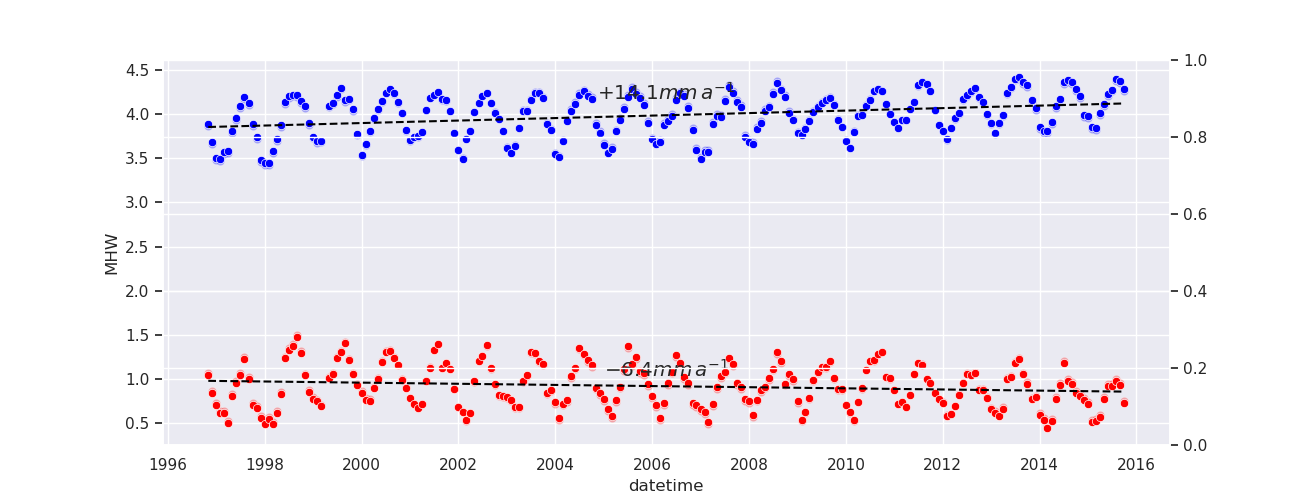

In [1040]:
fig = plt.figure(figsize=(13, 5))
ax = fig.subplots()

sns.scatterplot(data=lms.MHW.ts, color="blue", alpha=0.3, ax=ax)
sns.scatterplot(data=lms.MHW_n.ts, color="blue", ax=ax)
sns.lineplot(data=lms.MHW_n.lin_ts, ls="--", color="black", ax=ax)
ax.text(x=lms.MHW_n.lin_ts.index.mean(), y=lms.MHW_n.lin_ts.max(), ha="center", va="bottom", zorder=30, s="${:+.1f} mm \, a^{{-1}}$".format(lms.MHW_n.coef * 1000), fontsize="large", fontweight="bold")

sns.scatterplot(data=lms.MLW.ts, color="red", alpha=0.3, ax=ax)
sns.scatterplot(data=lms.MLW_n.ts, color="red", ax=ax)
sns.lineplot(data=lms.MLW_n.lin_ts, ls="--", color="black", ax=ax)
ax.text(x=lms.MLW_n.lin_ts.index.mean(), y=lms.MLW_n.lin_ts.max(), ha="center", va="bottom", zorder=30, s="${:+.1f} mm \, a^{{-1}}$".format(lms.MLW_n.coef * 1000), fontsize="large", fontweight="bold")

ax1 = ax.twinx()
sns.lineplot(x=data.index, y=filt, color="black", ls=":", ax=ax1, zorder=1, label="Nodal Tide", legend=False)
ax1.set_ylabel("Nodal Elevation (m)")
ax1.grid(False)

ax.set_ylabel("elevation")
ax.set_xlabel("")
fig.tight_layout()